Epoch 1/20


/tmp/ipython-input-5-3447463499.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.set_index('ds').resample('H').mean().reset_index()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.3882 - val_loss: 0.2671
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2472 - val_loss: 0.1103
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0717 - val_loss: 0.1674
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0837 - val_loss: 0.0499
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0433 - val_loss: 0.0548
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0375 - val_loss: 0.0470
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0309 - val_loss: 0.0578
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0378 - val_loss: 0.0471
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0379 - val_loss: 0.0466
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0380 - val_loss: 0.0466
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0309 - val_loss: 0.0482
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0365 - val_loss: 0.0467
Epoch 13/20


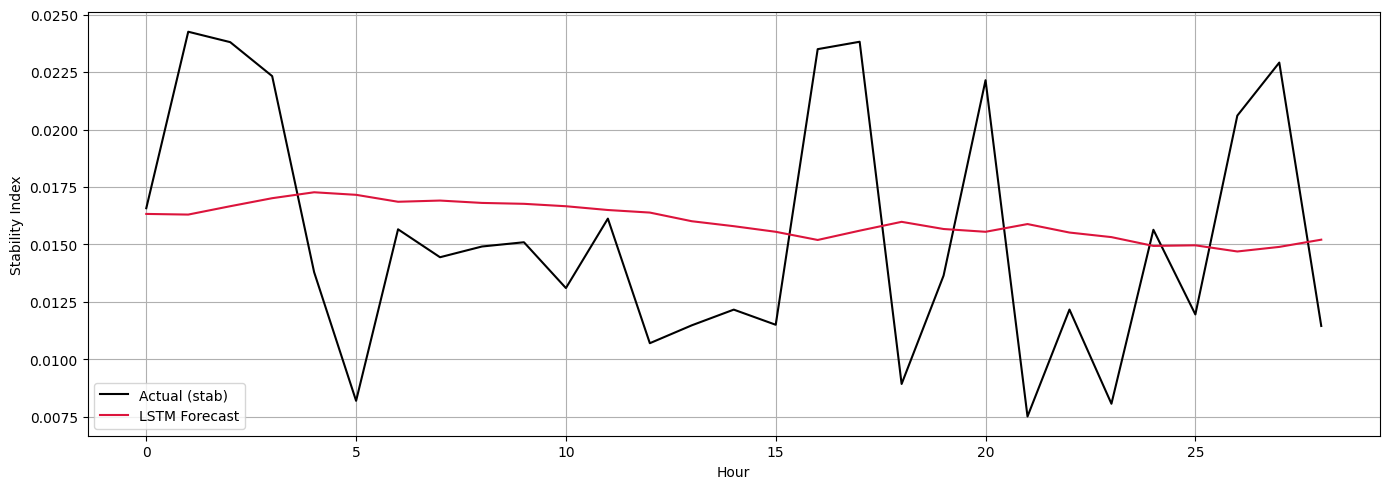

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# === STEP 1: Load Dataset (Colab-friendly path) ===
df = pd.read_csv("Data_for_UCI_named.csv")

# Simulate datetime index
start_time = datetime(2025, 1, 1, 0)
df['ds'] = [start_time + timedelta(minutes=i) for i in range(len(df))]

# Select and rename stability column
df = df[['ds', 'stab']].rename(columns={'stab': 'y'})

# Resample to hourly average
df = df.set_index('ds').resample('H').mean().reset_index()
df.dropna(inplace=True)

# === STEP 2: Normalize Target ===
scaler = MinMaxScaler()
df['y_scaled'] = scaler.fit_transform(df[['y']])

# === STEP 3: Create Time Series Sequences ===
def create_sequences(data, sequence_length=24):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 24
data_series = df['y_scaled'].values
X, y = create_sequences(data_series, sequence_length)

# Reshape for LSTM: [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split into training and testing sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === STEP 4: Build and Train LSTM Model ===
model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# === STEP 5: Evaluate and Plot Results ===
y_pred = model.predict(X_test)

# Inverse scale predictions
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Performance metrics
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mape = mean_absolute_percentage_error(y_test_rescaled, y_pred_rescaled) * 100

print("\n--- LSTM Forecast Performance ---")
print(f"MAE:  {mae:.3f} kWh")
print(f"RMSE: {rmse:.3f} kWh")
print(f"MAPE: {mape:.2f}%")

# Plot forecast
plt.figure(figsize=(14,5))
plt.plot(y_test_rescaled, label='Actual (stab)', color='black')
plt.plot(y_pred_rescaled, label='LSTM Forecast', color='crimson')
plt.xlabel("Hour")
plt.ylabel("Stability Index")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
